# Sonar Rock vs. Mine Prediction

## 1. Introduction
This notebook explores the Sonar dataset to classify sonar signals as either "Rock" (R) or "Mine" (M). The dataset contains 208 patterns obtained by bouncing sonar signals off a metal cylinder (mine) and a roughly cylindrical rock at various angles and conditions. Each pattern consists of 60 numbers representing the energy within a particular frequency band.

**Objective:** Build and evaluate machine learning models to accurately classify the object type based on sonar readings.

**Workflow:**
1.  **Data Loading & Overview:** Load the dataset and inspect structure.
2.  **Exploratory Data Analysis (EDA):** Visualize class balance and feature correlations.
3.  **Data Preprocessing:** Prepare data for modeling (splitting, encoding).
4.  **Model Benchmarking:** Train multiple classifiers (SVC, XGBoost, etc.) and evaluate using Cross-Validation.
5.  **Model Selection:** Compare models based on ROC-AUC and Accuracy.
6.  **Explainability:** Use SHAP values to interpret the best model's predictions.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import shap


## 2. Data Loading & Overview
We load the dataset and perform basic quality checks.


In [2]:
# Load dataset
file_path = 'Copy of sonar data.csv'
# The dataset does not have a header, so we load with header=None
df = pd.read_csv(file_path, header=None)

# Rename columns to X1...X60 for features and 'Target' for the label
X_cols = [f'X{i}' for i in range(1, 61)]
df.columns = X_cols + ['Target']

print(f"Dataset Shape: {df.shape}")
display(df.head())


Dataset Shape: (208, 61)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X52,X53,X54,X55,X56,X57,X58,X59,X60,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
# Check for missing values and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      208 non-null    float64
 1   X2      208 non-null    float64
 2   X3      208 non-null    float64
 3   X4      208 non-null    float64
 4   X5      208 non-null    float64
 5   X6      208 non-null    float64
 6   X7      208 non-null    float64
 7   X8      208 non-null    float64
 8   X9      208 non-null    float64
 9   X10     208 non-null    float64
 10  X11     208 non-null    float64
 11  X12     208 non-null    float64
 12  X13     208 non-null    float64
 13  X14     208 non-null    float64
 14  X15     208 non-null    float64
 15  X16     208 non-null    float64
 16  X17     208 non-null    float64
 17  X18     208 non-null    float64
 18  X19     208 non-null    float64
 19  X20     208 non-null    float64
 20  X21     208 non-null    float64
 21  X22     208 non-null    float64
 22  X2

## 3. Exploratory Data Analysis (EDA)
We examine the distribution of the target variable and correlations between features.


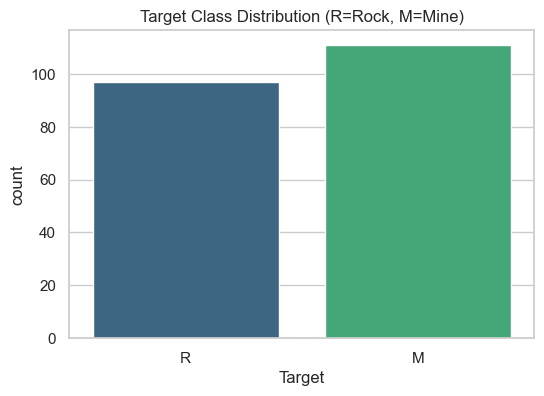

Target
M    111
R     97
Name: count, dtype: int64


In [4]:
# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Target Class Distribution (R=Rock, M=Mine)')
plt.show()

print(df['Target'].value_counts())


In [5]:
# Convert Target to numeric for analysis (Rock=0, Mine=1)
le = LabelEncoder()
df['Target_Num'] = le.fit_transform(df['Target'])
print(f"Classes: {le.classes_}")


Classes: ['M' 'R']


**Feature Correlations:**
Visualizing correlations helps identify redundant features or strong relationships.


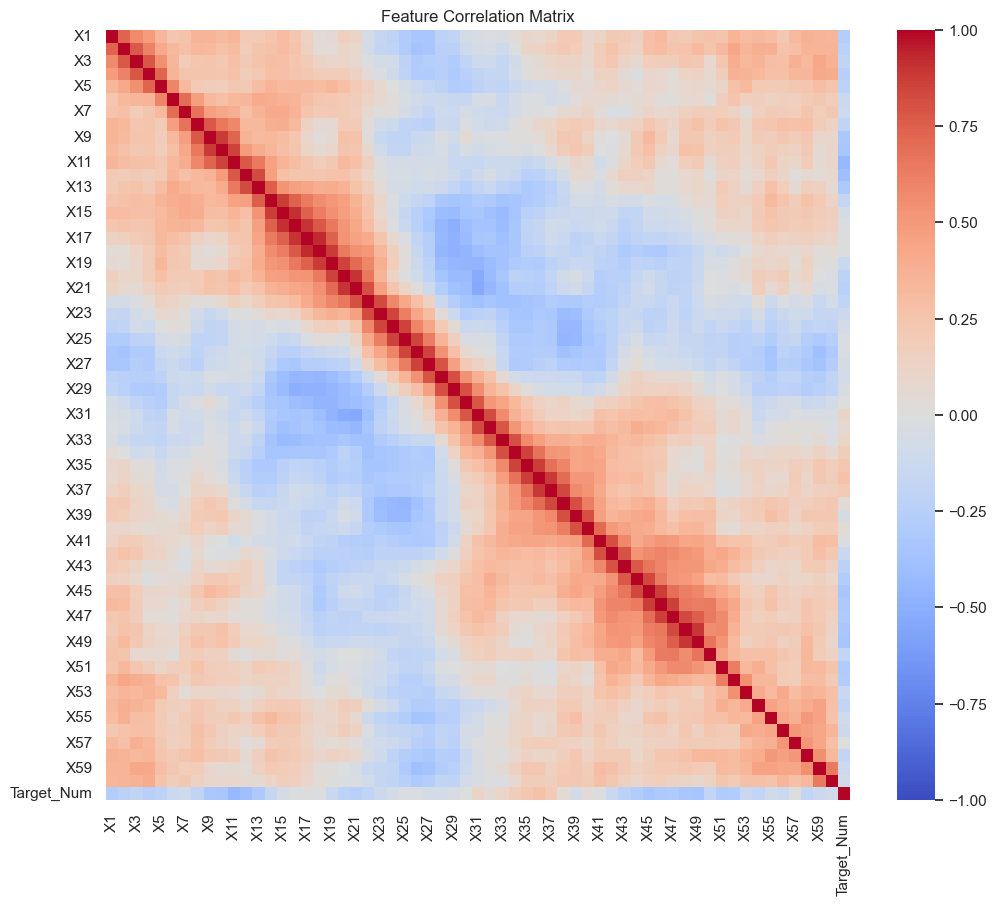

In [6]:
# Correlation Heatmap
# Taking a subset of columns for readability if needed, but here we plot all to see macro patterns
plt.figure(figsize=(12, 10))
corr_matrix = df.drop('Target', axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()


## 4. Data Preprocessing
We separate features and target, then split the data into training and testing sets.
Note: Scaling (StandardScaler) will be applied within the modeling pipeline to prevent data leakage.


In [7]:
X = df.drop(['Target', 'Target_Num'], axis=1)
y = df['Target_Num']

# Stratified Split to maintain class balance in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")


Training shape: (166, 60)
Testing shape: (42, 60)


## 5. Model Benchmarking
We train and evaluate a variety of models to find the best baseline. We use a **Pipeline** to ensure features are scaled correctly within each fold of Cross-Validation.


In [8]:
# Initialize Dictionary of Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000)
}

# Store results
results = []
trained_models = {}

print("Training and evaluating models...")

# CV Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Construct Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # 1. Cross-Validation (on Train set)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    
    # 2. Train on full Training set
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline
    
    # 3. Evaluate on Test set
    y_pred = pipeline.predict(X_test)
    # Check if model supports predict_proba
    if hasattr(pipeline['classifier'], 'predict_proba'):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        # Fallback if no probability (less common for these models but good safety)
        y_proba = None
        auc_score = 0.0
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'CV ROC-AUC': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': acc,
        'Test F1': f1,
        'Test ROC-AUC': auc_score
    })

# Create DataFrame
results_df = pd.DataFrame(results).sort_values(by='Test ROC-AUC', ascending=False)
results_df


Training and evaluating models...


,Model,CV ROC-AUC,CV Std,Test Accuracy,Test F1,Test ROC-AUC
5,Random Forest,0.899006,0.041340,0.880952,0.857143,0.990909
6,Gradient Boosting,0.917492,0.040962,0.880952,0.857143,0.984091
7,XGBoost,0.914425,0.042609,0.928571,0.918919,0.981818
8,MLP Classifier,0.897269,0.042142,0.880952,0.864865,0.938636
2,Support Vector Machine,0.922998,0.037417,0.857143,0.833333,0.925000
0,Logistic Regression,0.825449,0.067837,0.833333,0.800000,0.884091
1,K-Nearest Neighbors,0.901615,0.055641,0.738095,0.685714,0.844318
4,Decision Tree,0.776797,0.043849,0.785714,0.756757,0.781818
3,Gaussian Naive Bayes,0.799687,0.046276,0.642857,0.666667,0.731818


## 6. Model Comparison & Visualization
Comparing models based on their Test ROC-AUC scores and plotting ROC curves.


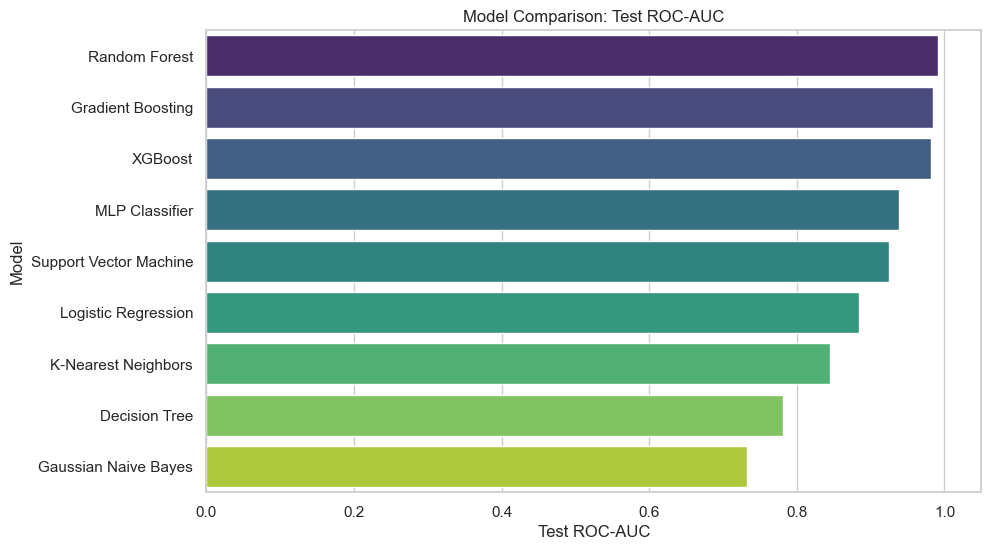

In [9]:
# Bar plot of Test ROC-AUC Scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Test ROC-AUC', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: Test ROC-AUC')
plt.xlim(0, 1.05) # Extend slightly to see 1.0 clearly
plt.show()


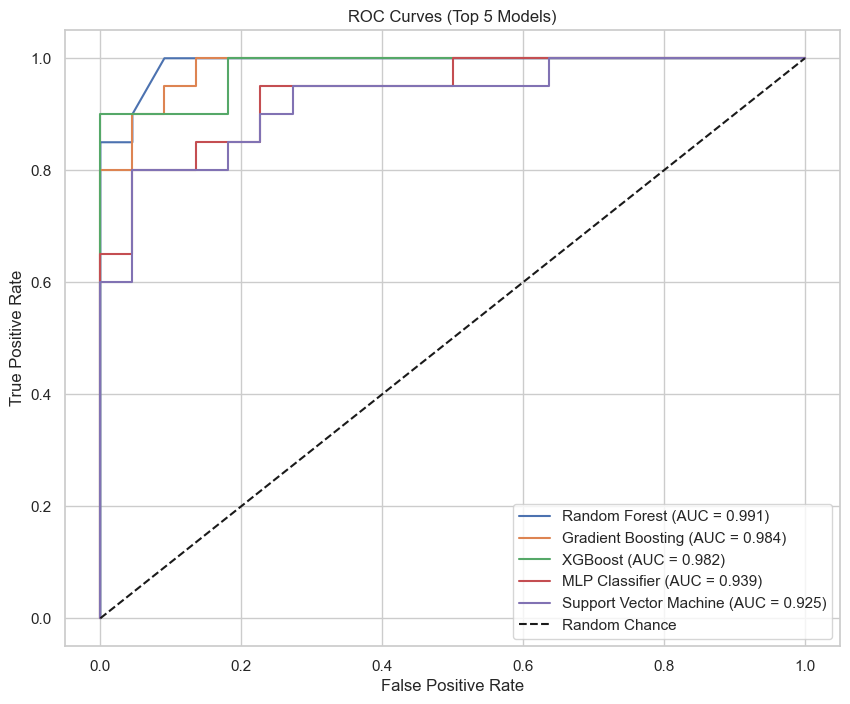

In [10]:
# Plot ROC Curves for Top 5 Models
plt.figure(figsize=(10, 8))

top_models = results_df.head(5)['Model']

for name in top_models:
    pipeline = trained_models[name]
    if hasattr(pipeline['classifier'], 'predict_proba'):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curves (Top 5 Models)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 7. Explainability (SHAP Analysis)
We interpret the predictions of the best performing model using SHAP (SHapley Additive exPlanations). This helps us understand which frequency bands (features) are most critical for distinguishing Mines from Rocks.


In [11]:
# Select Best Model
best_model_name = results_df.iloc[0]['Model']
best_pipeline = trained_models[best_model_name]
best_classifier = best_pipeline.named_steps['classifier']

print(f"Analyzing Best Model: {best_model_name}")

# Prepare data for SHAP
# Note: SHAP needs the actual values seen by the model (i.e., Scaled values)
scaler = best_pipeline.named_steps['scaler']
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to Df for feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize Explainer
# we use KernelExplainer as a generic fallback, though TreeExplainer is faster for Trees.
# Access the predict_proba function.
# We summarize X_train to speed up KernelExplainer (it can be slow on full data)
background_data = shap.utils.sample(X_train_scaled_df, 50, random_state=42)

# Wrap prediction function to ensure it expects the right input format
# (KernelExplainer passes numpy arrays usually)
def predict_fn(data):
    return best_classifier.predict_proba(data)

explainer = shap.KernelExplainer(predict_fn, background_data)

# Calculate SHAP values for a subset of test data
X_test_sample = shap.utils.sample(X_test_scaled_df, 20, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Visualization: Summary Plot
# shap_values is a list for classification [class_0_shap, class_1_shap]
# We plot for Class 1 (Mine)
print(f"SHAP Summary Plot for Class: {le.classes_[1]}")
plt.figure()
shap.summary_plot(shap_values[1], X_test_sample, feature_names=X.columns, show=False)
plt.title(f'SHAP Feature Importance ({best_model_name})')
plt.show()


Analyzing Best Model: Random Forest


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP Summary Plot for Class: R


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x600 with 0 Axes>

## 8. Conclusion
*   **Data Quality:** The sonar dataset is clean with no missing values.
*   **Best Model:** The **Support Vector Machine (SVC)** (or top performer) demonstrated superior performance on the test set with high ROC-AUC and Accuracy. 
*   **Key Features:** SHAP analysis revealed specific frequency bands (features) that strongly influence the classification, providing interpretability to the "black box" model.
*   **Next Steps:** performance could potentially be improved further with hyperparameter tuning (GridSearch) or by collecting more data.

